In [15]:
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

rng = np.random.default_rng()

import matplotlib.pyplot as plt
from trajectories import *
from plotting import *
from helpers import *

import cvxpy as cp
from kalman_filter import *

T = 250 # how long to simulate the trajectory
# num_traj = num_traj_train + num_traj_test
num_traj = 10

Trajectory shape (250, 2)
Measured shape (250, 2)
Recovered by LS shape (250, 2)


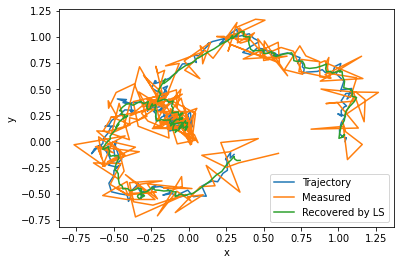

Average Error for LS Opt with CVX: 0.0032780858485753936


In [21]:
task_name = 'so2'
A, B, C, Q, R, x0, state_dim, input_dim, obs_dim = sys_params[task_name]
u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq)
# traj  has shape=(num_traj, T, state_dim)
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)

myMeas = meas[0]
myUseq = u_seq[0]
myTraj = traj[0]

ls_rec = optimal_traj(A, B, C, Q, R, myMeas, x0, myUseq)
err_opt = np.linalg.norm(ls_rec - myTraj)**2

plot({"Trajectory": myTraj, "Measured": myMeas, "Recovered by LS":ls_rec})
print('Average Error for LS Opt with CVX:', err_opt / T)

## Minimum energy noise Optimization Using CVX. Compare to Forward-Backward Kalman Smoothing

In [20]:
err_opt, err_kf_fwd, err_kf_bkwd, err_kf_smoothed = 0, 0, 0, 0

# plot a sample trajectory and noisy measurements
for i in range(num_traj):
    myTraj = traj[i]
    myMeas = meas[i]
    myUseq = u_seq[i]
    
    # Least Squares Optimization with CVX: Minimum Energy Noise
    ls_rec = optimal_traj(A, B, C, Q, R, myMeas, x0, myUseq)
    err_opt += np.linalg.norm(ls_rec - myTraj)**2
    
    # Kalman Filter Forward
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    fltr_fwd = kinematics_forward.simulate(myMeas, myUseq)
    err_kf_fwd += np.linalg.norm(fltr_fwd - myTraj)**2
    
    # Kalman Filter Backward
    kinematics_backward = KFilter(np.linalg.inv(A), -np.linalg.inv(A) @ B, C, Q, R, state=myTraj[-1])
    fltr_bkwd = np.flip(kinematics_backward.simulate(myMeas[::-1, :], myUseq[::-1, :]), axis=0)
    err_kf_bkwd += np.linalg.norm(fltr_bkwd - myTraj)**2
    
    # Kalman Smoothed (Avg forward and backward)
    smooth_states = (fltr_fwd + fltr_bkwd) / 2
    err_kf_smoothed += np.linalg.norm(smooth_states - myTraj)**2
    
    # Some plots
#     plot({"Trajectory": myTraj, "Measured": myMeas, "Recovered by LS":ls_rec, "Forward Kalman Filtered":fltr_fwd, 
#           "Backward Kalman Filtered":fltr_bkwd, "Smoothed":smooth_states})
    
print('Average Error for LS Opt with CVX:', err_opt / T / num_traj)
print('Average Error for KF Forward:', err_kf_fwd / T / num_traj)
print('Average Error for KF Backward:', err_kf_bkwd / T / num_traj)
print('Average Error for KF Smoothed:', err_kf_smoothed / T / num_traj)

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Average Error for LS Opt with CVX: 0.003073670373157014
Average Error for KF Forward: 0.005280663165776812
Average Error for KF Backward: 0.005475495669823175
Average Error for KF Smoothed: 0.0034732586295012835
